<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Conditional Auto-Encoder with the settings obtained from Optimization


In [1]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')

import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import logging
import sys
from sklearn import preprocessing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Reshape, LeakyReLU, BatchNormalization, Dense, Flatten, Input,Dropout
import random
import numpy as np
import pickle
import tensorflow_addons as tfa
import seaborn as sns
import pandas as pd



In [2]:
SMALL_SIZE =  14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.1
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

plotpath        = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'

if conditional:
    label_2='conditional_%s'%cond_on+label_2

In [4]:
random.seed(seeds[RUN])
np.random.seed(seeds[RUN])
tf.random.set_seed(seeds[RUN])

dim             = fixed_num_bins

optimizer       = tf.keras.optimizers.Adam
batchsize       = 33
decay_steps     = 2300
dropouts_dec    = [0.]
dropouts_enc    = [0.]
latent_dim      = 10
lr_final        = 1.3e-05
lr_init         = 7e-4
out_features    = [1000,590]

def dense_cond_block(x,z,num, non_lin=True):
    x = tf.concat([x,z], axis=1)
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)

def dense_block(x,num, non_lin=True):
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)



def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(data, training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}


def make_scheduler(length, initial_lr,factor=1.2):
    def scheduler(epoch, lr):
        if epoch < length:
            lr = initial_lr
            return lr
        else:
            return lr * tf.math.exp(-factor)
    return scheduler
                             
def training_cycle(BATCH_SIZE, n_epochs, lr_anneal, lr_initial, reduce_fac): 
    scheduler = make_scheduler(lr_anneal, lr_initial, reduce_fac)
    callback  = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history   = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_types, train_params), batch_size=BATCH_SIZE, epochs=n_epochs, callbacks=[callback],verbose=0)
    return history

def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1])])
    return valid_loss

In [5]:
try:
    train,valid,test,le = pickle.load(open(os.path.join(root_model_data,'combined_%s.pkl'%label_),'rb'))
    print('data loaded from file')
except:
    train_data = np.load(os.path.join(root_model_data,'train_%s.npy.npz'%label_))
    valid_data = np.load(os.path.join(root_model_data,'valid_%s.npy.npz'%label_))
    test_data = np.load(os.path.join(root_model_data,'test_%s.npy.npz'%label_))


    keys = ('spec', 'mask', 'noise', 'z', 'RA', 'DE', 'class', 'subclass','SN','MJD','plate','fiber', 'mean', 'std')

    train = {}
    for item, key in zip(train_data.files, keys):
        train[key] = train_data[item]


    valid = {}
    for item, key in zip(valid_data.files, keys):
        valid[key] =  valid_data[item]

    test = {}
    for item, key in zip(test_data.files, keys):
        test[key] = test_data[item]


    le = preprocessing.LabelEncoder()
    le.fit(train['subclass'])
    train['subclass'] = le.transform(train['subclass'])
    valid['subclass'] = le.transform(valid['subclass'])
    test['subclass']  = le.transform(test['subclass'])
    print(le.classes_, le.transform(le.classes_))        

    pickle.dump([train,valid,test,le],open(os.path.join(root_model_data,'combined_%s.pkl'%label_),'wb'))


data loaded from file


In [6]:
input        = Input(shape=(dim,1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))
input_type   = Input(shape=(1,1))
input_params = Input(shape=(1,1))

if cond_on=='type':
    z = input_type
if cond_on=='redshift':
    z = input_params

n_layers   = 3
latent_dim = latent_dim

x = input
for ii in range(n_layers-1):
    if ii>0:
        x = Dropout(dropouts_enc[ii-1])(x)
    x = dense_block(x,out_features[ii])
    
x = dense_block(x,latent_dim,non_lin=False)
x = Reshape((latent_dim,1))(x)

for ii in range(n_layers-1):
    if conditional:
        x = dense_cond_block(x,z,out_features[-1-ii])
    else:
        x = dense_block(x,out_features[-1-ii])
    if ii ==0:
        pass
    else:
        x = Dropout(dropouts_dec[ii-1])(x)
if conditional:
    x = dense_cond_block(x,z,dim, non_lin=False)
else:
    x = dense_block(x,dim, non_lin=False)


learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
lr_init,
decay_steps,
lr_final,
power=0.5, cycle=True)

optim = optimizer

lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_type, input_params], outputs=x)
lstm_ae.compile(optimizer=optim(learning_rate=learning_rate_fn), my_loss=lossFunction, metrics=[],run_eagerly=False)
lstm_ae.summary()

Model: "custom_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1000)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1000)         1001000     flatten[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1000)         0           dense[0][0]                      
_______________________________________________________________________________________

In [7]:
path = os.path.join(root_models,'full_ae_model_%s_run%s'%(label_2,RUN))

lstm_ae.fit(x=(train['spec'],train['mask'],train['noise'], np.expand_dims(train['subclass'],-1), np.expand_dims(train['z'],-1)), batch_size=batchsize, epochs=EPOCHS)

res_valid   = lstm_ae.predict((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']))
recon_error = custom_metric((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']),res_valid)

print('final validation loss:', recon_error)
print('final validation reconstruction error:', np.sqrt(recon_error))


lstm_ae.save(path)

Epoch 1/40
1632/1632 [==============================] - 3s 2ms/step - training_loss: 5.5881
Epoch 2/40
1632/1632 [==============================] - 3s 2ms/step - training_loss: 2.2294
Epoch 3/40
1632/1632 [==============================] - 3s 2ms/step - training_loss: 1.8208
Epoch 4/40
1632/1632 [==============================] - 3s 2ms/step - training_loss: 1.7847
Epoch 5/40
1632/1632 [==============================] - 3s 2ms/step - training_loss: 1.8041
Epoch 6/40
1632/1632 [==============================] - 3s 2ms/step - training_loss: 1.7091
Epoch 7/40
1632/1632 [==============================] - 3s 2ms/step - training_loss: 1.5453
Epoch 8/40
1632/1632 [==============================] - 3s 2ms/step - training_loss: 1.6225
Epoch 9/40
1632/1632 [==============================] - 3s 2ms/step - training_loss: 1.5531
Epoch 10/40
1632/1632 [==============================] - 3s 2ms/step - training_loss: 1.4851
Epoch 11/40
1632/1632 [==============================] - 3s 2ms/step - training

In [8]:
for label in np.arange(7):
    print(le.inverse_transform([label]))
    index = np.where(valid['subclass']==label)[0]
    res_valid = lstm_ae.predict((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]))
    print('validation: ', custom_metric((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]),res_valid))
    index = np.where(train['subclass']==label)[0]
    lng   = min(len(res_valid),len(index))
    res_train = lstm_ae.predict((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]))
    print('training: ', custom_metric((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]),res_train))

[b'']
validation:  1.2534258469803903
training:  1.2541483795107913
[b'AGN']
validation:  1.4541528586373786
training:  1.424996133087084
[b'AGN BROADLINE']
validation:  1.9405595908138473
training:  1.8127236322698228
[b'BROADLINE']
validation:  1.7288738485470405
training:  1.624845027818506
[b'STARBURST']
validation:  1.6291661212590949
training:  1.5807762330909954
[b'STARBURST BROADLINE']
validation:  1.8016979439471694
training:  1.6549227955431451
[b'STARFORMING']
validation:  1.4512937079731443
training:  1.3943631222753496


In [9]:
def bootstrap(train_data, batch_size):
    index   = np.arange(len(train['spec']))
    metrics = []
    for ii in range(1000):
        sample    = np.random.choice(index, size=batch_size, replace=False, p=None)
        res_train = lstm_ae.predict((train['spec'][sample],train['mask'][sample],train['noise'][sample], train['subclass'][sample],train['z'][sample]))
        metric    = custom_metric((train['spec'][sample],train['mask'][sample],train_data['noise'][sample], train['subclass'][sample],train['z'][sample]),res_train)
        metrics.append(metric)
    return np.mean(metrics), np.std(metrics)

In [10]:
#bootstrap(train, batch_size=len(valid['spec']))

In [11]:
### concatenate and split input
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        new_model.add(curr_layer)
    return new_model

In [12]:
def extract_layers_base(main_model, starting_layer_ix, ending_layer_ix):
    layers=[]
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        layers.append(curr_layer)
    return layers

In [13]:
encoder = extract_layers(lstm_ae,0,13)
encoder.build((None,fixed_num_bins,1))
encoder.summary()

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x2aab977462e0>
1 <tensorflow.python.keras.layers.core.Flatten object at 0x2aab97796bb0>
2 <tensorflow.python.keras.layers.core.Dense object at 0x2aab97796d00>
3 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aab979bd970>
4 <tensorflow.python.keras.layers.core.Reshape object at 0x2aab979bdbe0>
5 <tensorflow.python.keras.layers.core.Dropout object at 0x2aab979bd730>
6 <tensorflow.python.keras.layers.core.Flatten object at 0x2aab97a16df0>
7 <tensorflow.python.keras.layers.core.Dense object at 0x2aab979eff10>
8 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aab97e55640>
9 <tensorflow.python.keras.layers.core.Reshape object at 0x2aab97e55d90>
10 <tensorflow.python.keras.layers.core.Flatten object at 0x2aab97796700>
11 <tensorflow.python.keras.layers.core.Dense object at 0x2aab97e55a00>
12 <tensorflow.python.keras.layers.core.Reshape object at 0x2aab97e65790>
Model: "

In [14]:
if conditional:
    decoder = extract_layers_base(lstm_ae,13,25)
    input      = Input(shape=(latent_dim,1))
    input_type = Input(shape=(1,1))
    print(decoder[0])
    x          = decoder[0]((input,input_type))
    for ii in range(1,len(decoder)):
        try:
            x = decoder[ii](x)
        except:
            x = decoder[ii]((x, input_type))
    decoder = Model((input,input_type),x)
else:
    decoder = extract_layers(lstm_ae,13,25)
    decoder.build((None,latent_dim,1))

13 <tensorflow.python.keras.layers.core.Reshape object at 0x2aab97e552e0>
14 <tensorflow.python.keras.layers.core.Flatten object at 0x2aab97e65730>
15 <tensorflow.python.keras.layers.core.Dense object at 0x2aab97e6c0d0>
16 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aab97e74e50>
17 <tensorflow.python.keras.layers.core.Reshape object at 0x2aab97e74d00>
18 <tensorflow.python.keras.layers.core.Flatten object at 0x2aab97e7bee0>
19 <tensorflow.python.keras.layers.core.Dense object at 0x2aab97e7bdf0>
20 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aab97e83d30>
21 <tensorflow.python.keras.layers.core.Reshape object at 0x2aab97e83e80>
22 <tensorflow.python.keras.layers.core.Dropout object at 0x2aab97e89970>
23 <tensorflow.python.keras.layers.core.Flatten object at 0x2aab97e65490>
24 <tensorflow.python.keras.layers.core.Dense object at 0x2aab97e937f0>


In [15]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 590)               6490      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 590)               0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 590, 1)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 590)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)             

In [16]:
encoded_valid = encoder.predict(valid['spec'])
encoded_train = encoder.predict(train['spec'])
encoded_test  = encoder.predict(test['spec'])

In [17]:
if conditional:
    decoded_train  = decoder.predict((np.expand_dims(encoded_train,-1), np.expand_dims(train['subclass'],-1)))
    decoded_test   = decoder.predict((np.expand_dims(encoded_test,-1), np.expand_dims(test['subclass'],-1)))
    decoded_valid  = decoder.predict((np.expand_dims(encoded_valid,-1), np.expand_dims(valid['subclass'],-1)))
else:
    decoded_train  = decoder.predict(encoded_train)
    decoded_test   = decoder.predict(encoded_test)
    decoded_valid  = decoder.predict(encoded_valid)   

In [18]:
path = os.path.join(root_models,'encoder_%s_run%s'%(label_2, RUN))
encoder.save(path)
path = os.path.join(root_models,'decoder_%s_run%s'%(label_2, RUN))
decoder.save(path)
print(path)

INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/encoder_galaxies_quasars_bins1000_wl3388-8318_minz010_maxz036_minSN50_10_fully_connected_mean_div_run1/assets
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz010_maxz036_minSN50_10_fully_connected_mean_div_run1/assets
/global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz010_maxz036_minSN50_10_fully_connected_mean_div_run1


In [19]:
path = os.path.join(root_models,'encoder_%s_run%s'%(label_2, RUN))
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s_run%s'%(label_2, RUN))
decoder = tf.keras.models.load_model(path)

In [20]:
encoded_valid = np.squeeze(encoded_valid)
encoded_train = np.squeeze(encoded_train)
encoded_test  = np.squeeze(encoded_test)

In [21]:
np.save(os.path.join(root_encoded,'encoded_%s_RUN%s.npy'%(label_2,RUN)),[encoded_train, encoded_valid, encoded_test])
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s_RUN%s.npy'%(label_2,RUN)), allow_pickle=True)

In [22]:
np.save(os.path.join(root_decoded,'decoded_%s_RUN%s.npy'%(label_2,RUN)),[decoded_train,decoded_valid, decoded_test, train['mean'], train['std']])

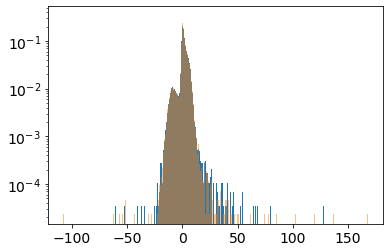

In [23]:
_=plt.hist(encoded_valid.flatten(),bins=1000,density=True, log=True)
_=plt.hist(encoded_train[:len(encoded_valid)].flatten(),bins=1000,density=True, alpha=0.5, log=True)

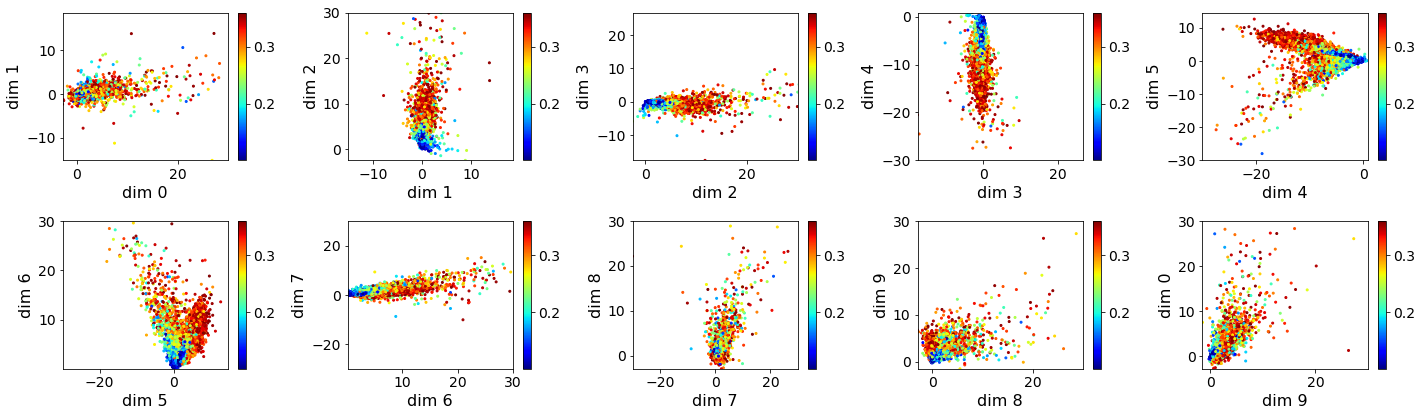

In [24]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['z'], cmap='jet',s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_redshift_AE1.pdf'), bbox_inches='tight')
plt.show()


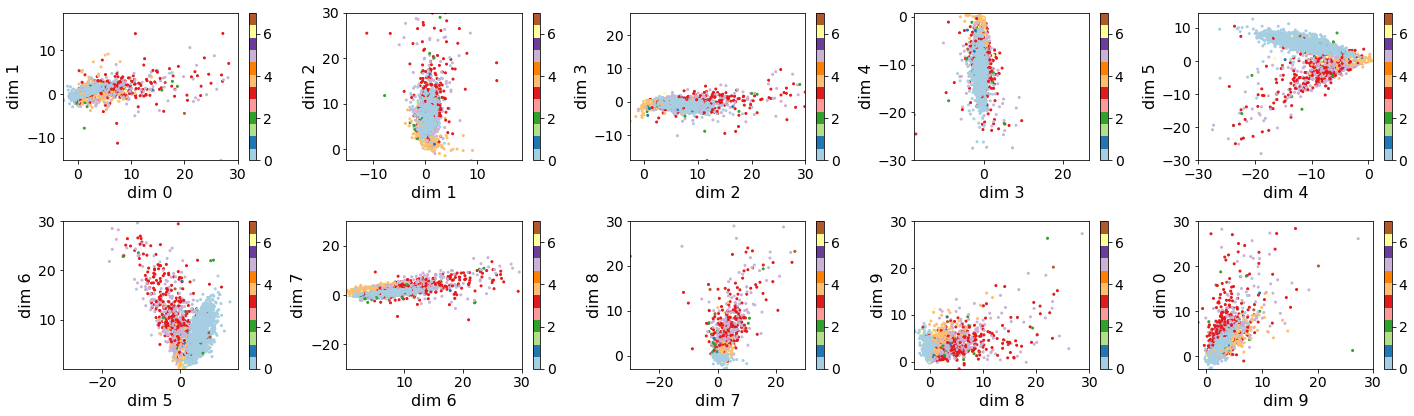

In [25]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['subclass'], cmap='Paired', s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_subclass_AE1.pdf'), bbox_inches='tight')
plt.show()


In [26]:
noise            = np.ma.array(np.squeeze(valid['noise']),mask=~np.squeeze(valid['mask'].astype('bool')))
recon_error      = np.ma.mean(np.ma.array(np.squeeze(valid['spec'])-decoded_valid,mask=~np.squeeze(valid['mask'].astype('bool')))**2*noise,axis=1)

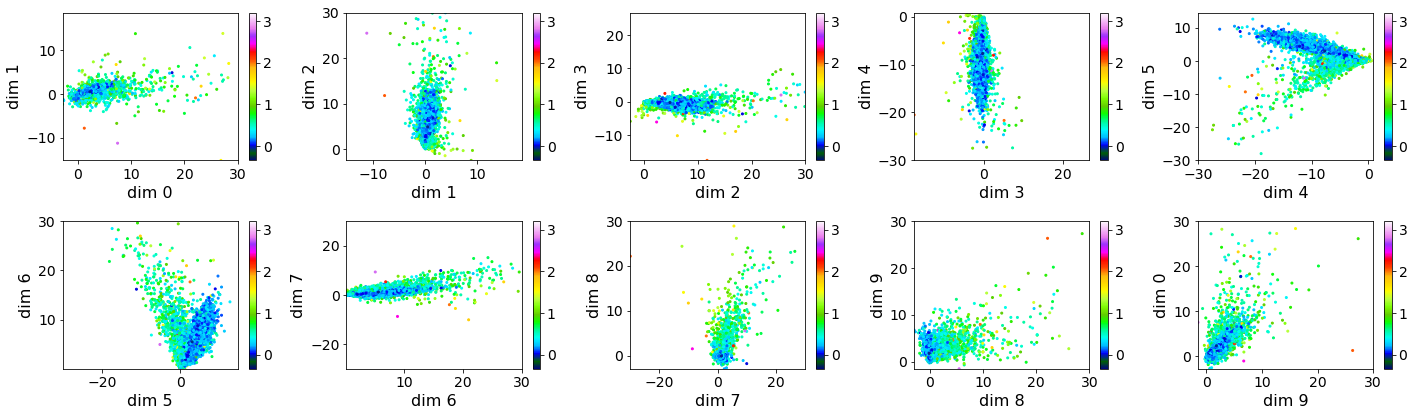

In [27]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=np.log(recon_error), cmap='gist_ncar', s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_noise_AE1.pdf'), bbox_inches='tight')
plt.show()

In [28]:
wlmin, wlmax    = (3388,8318)
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

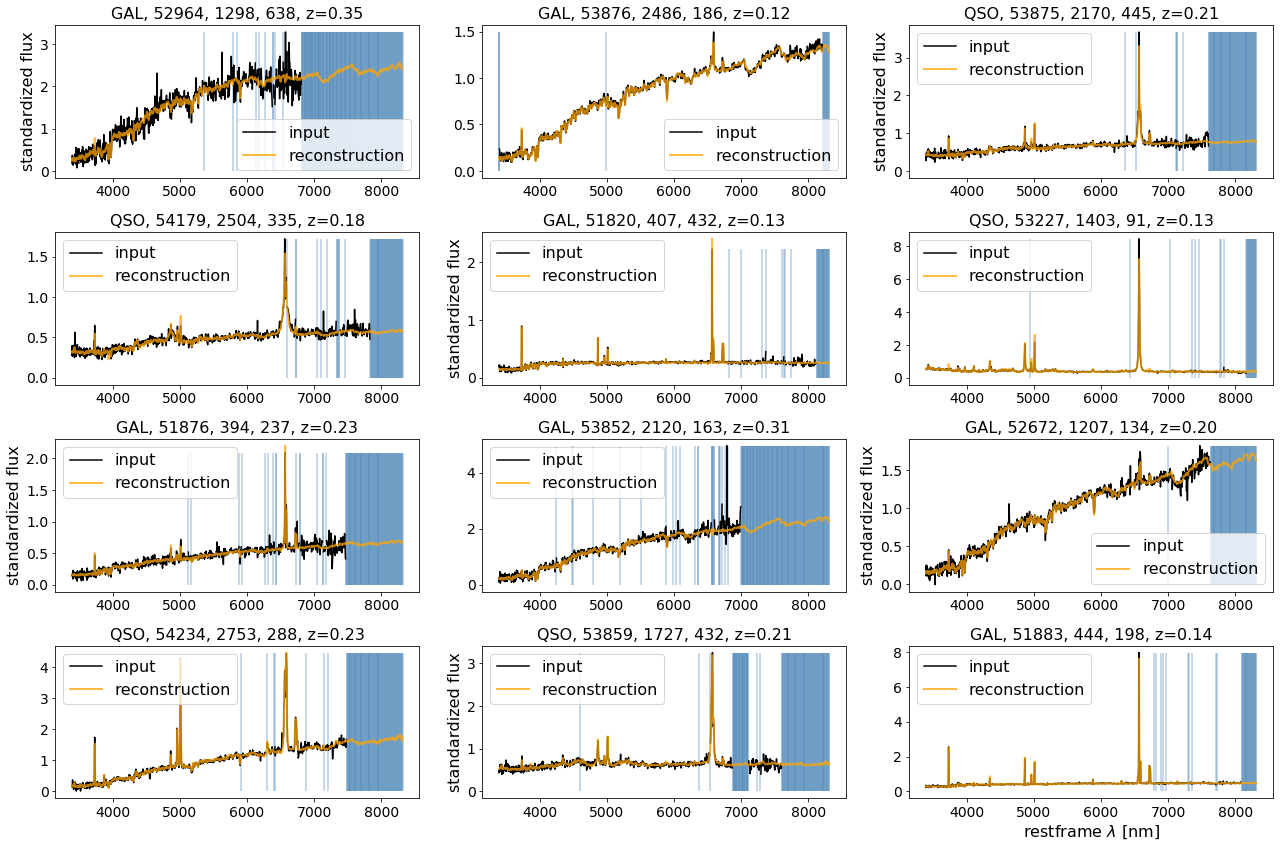

In [29]:
masked={}
masked['train'] = np.ma.array(np.squeeze(train['spec']),mask=~np.squeeze(train['mask'].astype('bool')))
masked['valid'] = np.ma.array(np.squeeze(valid['spec']),mask=~np.squeeze(valid['mask'].astype('bool')))
masked['test'] = np.ma.array(np.squeeze(test['spec']),mask=~np.squeeze(test['mask'].astype('bool')))
classes = {2:'GAL', 1:'QSO', 0:'STAR'}
fi, ax = plt.subplots(4,3,figsize=(18,12))
ax     = ax.flatten()
for ii in range(12):
    ind = (test['subclass']==(ii%7))
    ax[ii].set_title('%s, %d, %d, %d, z=%.2f'%(classes[test['class'][ind][ii]], test['MJD'][ind][ii],test['plate'][ind][ii],test['fiber'][ind][ii],test['z'][ind][ii]))
    ax[ii].plot(new_wl[1:],masked['test'][ind][ii],label='input', color='black')
    ax[ii].vlines(x=new_wl[1:][np.squeeze(~test['mask'][ind][ii].astype(bool))], ymin=0,ymax=max(test['spec'][ind][ii]), color='steelblue',alpha=0.4)
    ax[ii].plot(new_wl[1:],decoded_test[ind][ii], label='reconstruction',ls='-', color='orange', lw=2, alpha=0.75)

    ax[ii].legend()
    if ii in [11,12]:
        ax[ii].set_xlabel(r'restframe $\lambda$ [nm]')
    if ii%2==0:
        ax[ii].set_ylabel(r'standardized flux')        
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'reconstructions_test_AE1.pdf'), bbox_inches='tight')
plt.show()

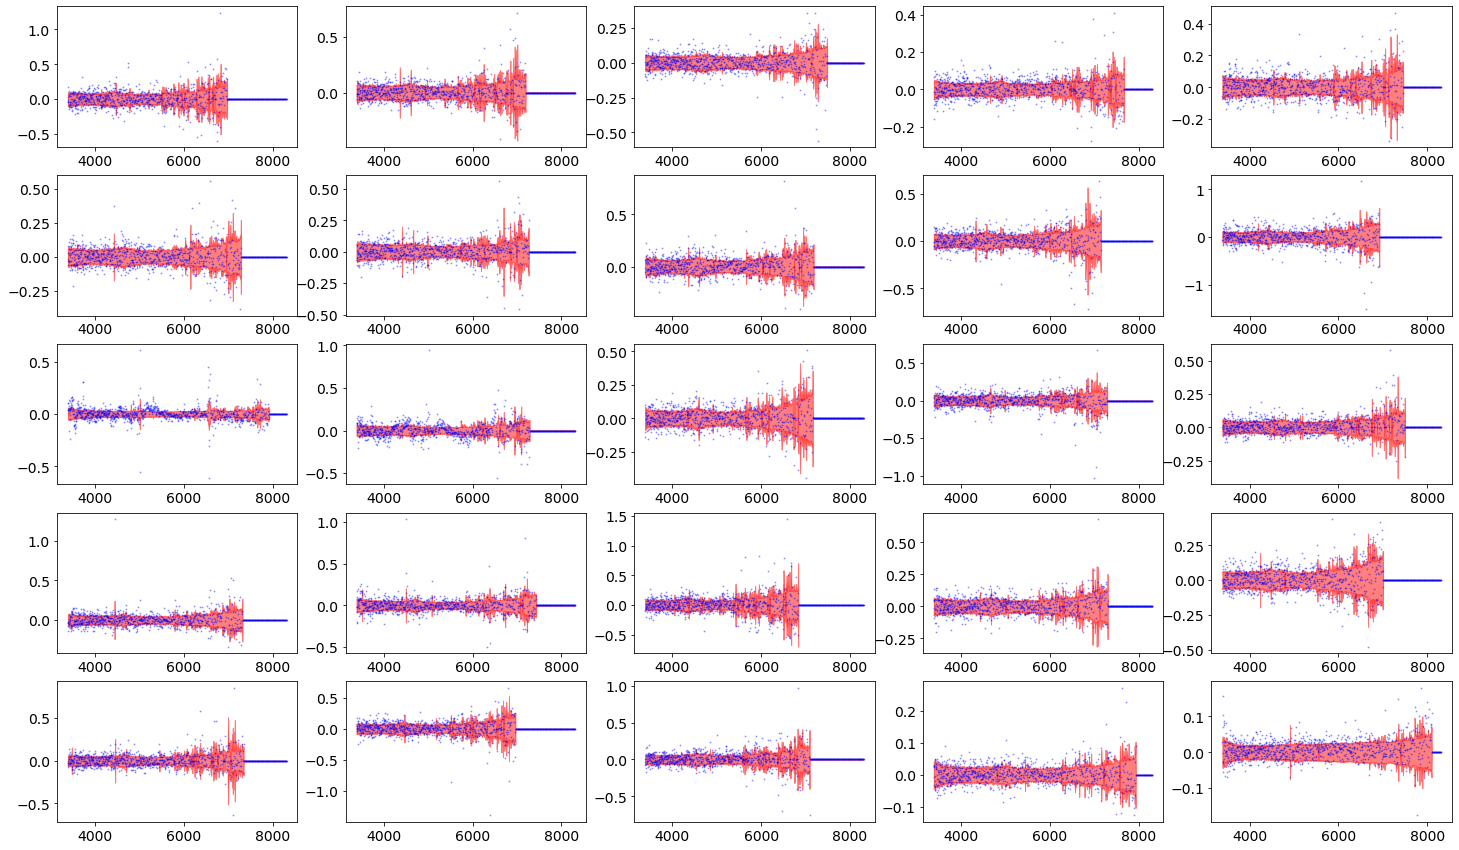

In [30]:
noise = np.zeros(valid['noise'].shape)
ind   = np.where(valid['noise']!=0)
noise[ind] = np.sqrt(1./np.squeeze(valid['noise'][ind]))

noise = np.squeeze(noise)


fig, ax = plt.subplots(5,5, figsize=(25,15))
ax = ax.flatten()
for nn, ii in enumerate(np.arange(25)):
    ax[nn].plot(new_wl[:-1], (np.squeeze(valid['spec'])[ii]-decoded_valid[ii])*np.squeeze(valid['mask'][ii]),color='blue', alpha=0.3,ls='',marker='o', markersize=1)
    ax[nn].fill_between(new_wl[:-1], -noise[ii], noise[ii], alpha=0.5, color='red')               
plt.show()

In [31]:
### Look at reconstruction ability as function of wavelength

In [32]:
def loss_by_wl(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]*y_true[1]
    valid_loss     = np.mean(loss,axis=0)
    std_valid_loss = np.std(loss,axis=0)
    return valid_loss, std_valid_loss

In [33]:
loss = loss_by_wl((valid['spec'],valid['mask'],valid['noise']),np.expand_dims(decoded_valid,-1))

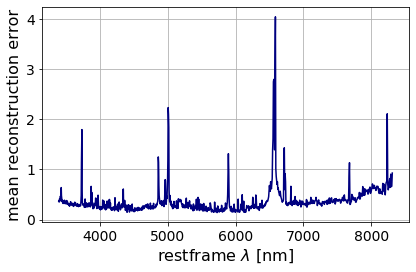

In [34]:
plt.plot(new_wl[:-1],loss[0]/np.mean(valid['mask'],axis=0)-1,color='navy')
plt.xlabel(r'restframe $\lambda$ [nm]')
plt.ylabel('mean reconstruction error')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'mean_reconstruction_error_AE1.pdf'), bbox_inches='tight')